In [6]:
import datetime

In [7]:
def df_detected_to_labeled(df_simulated, df_detected):
    df_labeled_b_ = pd.merge(
        df_simulated,
        df_detected[df_detected["open_side"] == "buy"],
        left_on=["time", "buyer"],
        right_on=["open_time", "wallet_id",],
    )
    df_labeled__s = pd.merge(
        df_simulated,
        df_detected[df_detected["close_side"] == "sell"],
        left_on=["time", "seller"],
        right_on=["close_time", "wallet_id",],
    )
    df_labeled_s_ = pd.merge(
        df_simulated,
        df_detected[df_detected["open_side"] == "sell"],
        left_on=["time", "seller"],
        right_on=["open_time", "wallet_id",],
    )
    df_labeled__b = pd.merge(
        df_simulated,
        df_detected[df_detected["close_side"] == "buy"],
        left_on=["time", "buyer"],
        right_on=["close_time", "wallet_id",]
    )

    df_labeled = pd.concat([
        df_labeled_b_,
        df_labeled__s,
        df_labeled_s_,
        df_labeled__b,
    ])

    df_labeled = df_labeled[["buyer", "seller", "time", "price", "size", "wash"]].dropna()
    df_labeled = df_labeled.drop_duplicates()


    df_matrix_prediction = pd.merge(
        df_simulated,
        df_labeled,
        on=["buyer", "seller", "time", "price", "size"],
        how="outer"
    ).rename({"wash_x": "true_label", "wash_y": "prediction_label"}, axis="columns")

    df_matrix_prediction[~df_matrix_prediction["prediction_label"].isna()] = True
    df_matrix_prediction["prediction_label"] = df_matrix_prediction["prediction_label"].fillna(False)
    df_matrix_prediction["true_label"] = (df_matrix_prediction["true_label"] != "No")

    return df_matrix_prediction

import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

def analyze_labels(df):
    # Extract columns
    y_true = df["true_label"].astype(bool)
    y_pred = df["prediction_label"].astype(bool)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print("=== Confusion Matrix ===")
    print(f"TP (correct wash detected):      {tp}")
    print(f"FP (false wash alarms):          {fp}")
    print(f"FN (missed wash trades):         {fn}")
    print(f"TN (correct non-wash):           {tn}")
    print()

    # Core metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print("=== Metrics ===")
    print(f"Accuracy:       {acc:.4f}")
    print(f"Precision:      {prec:.4f}")
    print(f"Recall:         {rec:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    print()

    # Rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    print("=== Error Rates ===")
    print(f"False Positive Rate:  {fpr:.4f}")
    print(f"False Negative Rate:  {fnr:.4f}")
    print()

    # Classification report
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=["No Wash", "Wash"]))


In [8]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def simulate_trades(df_original, n_trades=10000, seed=None):
    """
    Simulate a sequence of trades based on statistical patterns learned
    from an existing trades dataframe.

    Output columns:
        buyer (int), seller (int), time, price, size
    """

    # ================================================================
    # 0. Preparation
    # ================================================================
    if seed is not None:
        np.random.seed(seed)

    df = df_original.copy()

    # Ensure datetime
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)

    # ================================================================
    # 1. GLOBAL MARKET-LEVEL INTER-TRADE TIME (THIS FIXES YOUR ISSUE)
    # ================================================================
    market_dt = df['time'].diff().dt.total_seconds().dropna()
    market_dt = market_dt[market_dt > 0]   # remove zeros if present

    if len(market_dt) == 0:
        global_dt_mean = 1.0
    else:
        global_dt_mean = market_dt.mean()

    # empirical sampling (best)
    def sample_dt():
        return float(np.random.choice(market_dt.values))

    # ================================================================
    # 2. WALLET-LEVEL ACTIVITY DISTRIBUTION
    # ================================================================

    sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
    sells["is_ask"] = True
    buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
    buys["is_ask"] = False
    df_all = pd.concat([sells, buys], ignore_index=True)

    df_all["notional"] = df_all["price"] * df_all["size"]
    df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
    df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
    wallet_stream = df_all.drop("notional", axis=1)

    wallet_counts = wallet_stream['wallet_id'].value_counts().sort_index()
    wallet_ids = wallet_counts.index.to_numpy()
    wallet_prob = (wallet_counts / wallet_counts.sum()).to_numpy()

    # Sample wallet according to its historical activity
    def sample_wallet():
        return int(np.random.choice(wallet_ids, p=wallet_prob))

    # Sample buyer and seller, avoid equal wallets
    def sample_wallet_pair():
        seller = sample_wallet()
        buyer = seller
        # avoid self-trade
        for _ in range(10):
            buyer = sample_wallet()
            if buyer != seller:
                break
        return buyer, seller

    # ================================================================
    # 3. WALLET-LEVEL SIZE STATISTICS
    # ================================================================
    size_stats = wallet_stream.groupby('wallet_id')['size'].agg(['mean', 'std'])
    global_size_mean = wallet_stream['size'].mean()
    global_size_std = wallet_stream['size'].std()

    def sample_size(wallet_id):
        if wallet_id in size_stats.index:
            mu = size_stats.loc[wallet_id, 'mean']
            sigma = size_stats.loc[wallet_id, 'std']
        else:
            mu = global_size_mean
            sigma = global_size_std

        # fallbacks
        if not np.isfinite(mu) or mu <= 0:
            mu = global_size_mean
        if not np.isfinite(sigma) or sigma <= 0:
            sigma = global_size_std

        # truncated normal > 0
        size = np.random.normal(mu, sigma)
        for _ in range(10):
            if size > 0:
                break
            size = np.random.normal(mu, sigma)
        return float(max(size, 1e-8))

    # ================================================================
    # 4. PRICE DYNAMICS: RANDOM WALK WITH SIZE-BASED VOL SCALED
    # ================================================================
    df_sorted = df.sort_values("time")
    price_series = df_sorted['price'].values
    price_series = price_series[price_series > 0]

    if len(price_series) > 1:
        log_ret = np.diff(np.log(price_series))
        base_sigma = np.std(log_ret)
        if not np.isfinite(base_sigma):
            base_sigma = 0.001
    else:
        base_sigma = 0.001

    # start price = last historical price
    start_price = float(df_sorted['price'].iloc[-1])

    def update_price(prev_price, trade_size):
        if prev_price <= 0:
            prev_price = 1.0

        # scale volatility by sqrt(size / mean_size)
        if global_size_mean > 0:
            scale = (trade_size / global_size_mean) ** 0.5
        else:
            scale = 1.0

        sigma = base_sigma * scale
        shock = np.random.normal(0, sigma)
        new_price = prev_price * np.exp(shock)

        if new_price <= 0 or not np.isfinite(new_price):
            new_price = prev_price

        return float(new_price)

    # ================================================================
    # 5. SIMULATION LOOP
    # ================================================================
    sim_records = []

    time_t = df_sorted['time'].iloc[-1]
    price_t = start_price

    for _ in tqdm(range(n_trades), desc="Simulating trades"):
        # 1. time
        dt = sample_dt()
        time_t = time_t + pd.Timedelta(seconds=dt)

        # 2. participants
        buyer, seller = sample_wallet_pair()

        # 3. size
        size = sample_size(seller)

        # 4. price
        price_t = update_price(price_t, size)

        sim_records.append({
            'buyer': buyer,
            'seller': seller,
            'time': time_t,
            'price': price_t,
            'size': size
        })

    df_sim = pd.DataFrame(sim_records)
    return df_sim


In [9]:
from src.data_handler import CoinDataStore

store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [10]:
df_simulated = simulate_trades(df_all_matched, n_trades=1100000, seed=71)

Simulating trades:   0%|          | 0/1100000 [00:00<?, ?it/s]

In [11]:
df_simulated["wash"] = "No"

In [12]:
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 1. Market-wide volume comparison
# -----------------------------------------------------
def compare_total_volume(df_original, df_sim, bin_size='1H'):
    """
    Plot total volume per time bin for original and simulated trades.
    """
    df1 = df_original.copy()
    df2 = df_sim.copy()

    df1['time'] = pd.to_datetime(df1['time'])
    df2['time'] = pd.to_datetime(df2['time'])

    # Aggregate sizes per bin
    vol_orig = df1.resample(bin_size, on='time')['size'].sum()
    vol_sim  = df2.resample(bin_size, on='time')['size'].sum()

    plt.figure(figsize=(14, 6))
    plt.plot(vol_orig.index, vol_orig.values, label='Original Volume', linewidth=2)
    plt.plot(vol_sim.index,  vol_sim.values,  label='Simulated Volume', linewidth=2)

    plt.title(f"Total Market Volume per {bin_size}")
    plt.xlabel("Time")
    plt.ylabel("Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_18882/168880220.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vol_orig = df1.resample(bin_size, on='time')['size'].sum()
/tmp/ipykernel_18882/168880220.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vol_sim  = df2.resample(bin_size, on='time')['size'].sum()


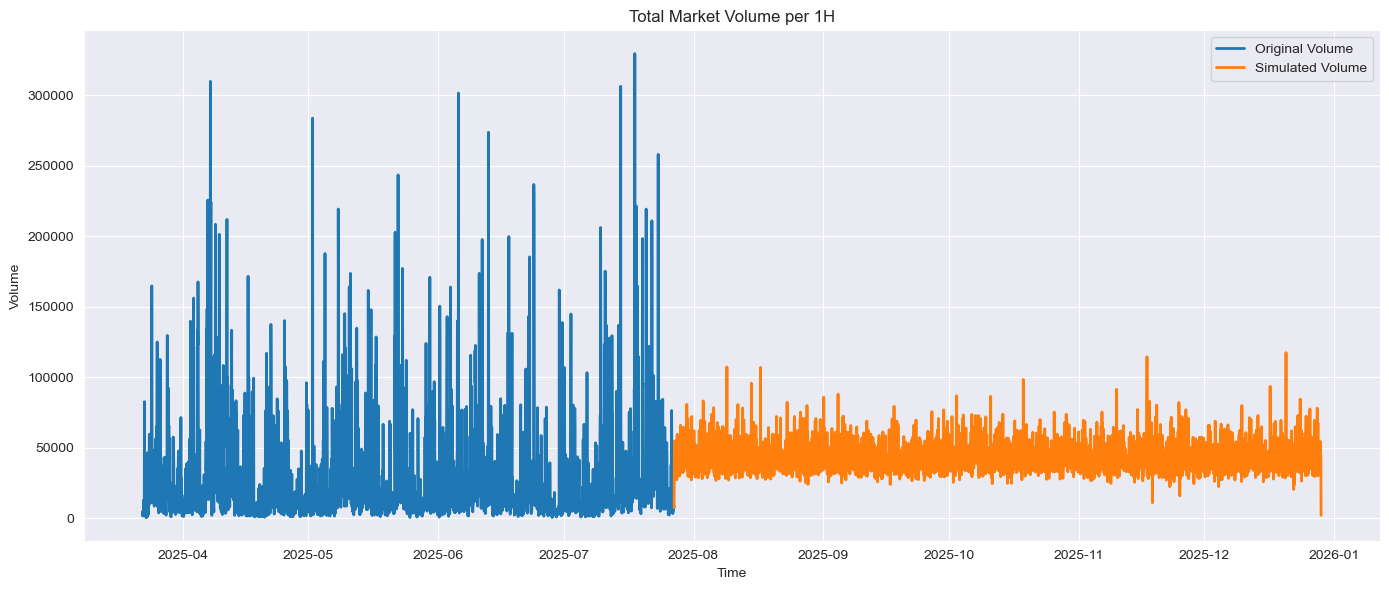

In [13]:
compare_total_volume(df_all_matched, df_simulated)

In [14]:
# -----------------------------------------------------
# 2. Wallet-specific volume comparison
# -----------------------------------------------------
def compare_wallet_volume(df_original, df_sim, wallet_id, bin_size='1H'):
    """
    Plot volume per time bin for a specific wallet (buyer OR seller).
    """

    # Extract wallet participation
    def extract_wallet(df):
        return df[(df['buyer'] == wallet_id) | (df['seller'] == wallet_id)]

    df1 = extract_wallet(df_original).copy()
    df2 = extract_wallet(df_sim).copy()

    if len(df1) == 0:
        print("Wallet not found in original data.")
    if len(df2) == 0:
        print("Wallet not found in simulated data.")

    df1['time'] = pd.to_datetime(df1['time'])
    df2['time'] = pd.to_datetime(df2['time'])

    vol_orig = df1.resample(bin_size, on='time')['size'].sum()
    vol_sim  = df2.resample(bin_size, on='time')['size'].sum()

    plt.figure(figsize=(14, 6))
    plt.plot(vol_orig.index, vol_orig.values, label='Original', linewidth=2)
    plt.plot(vol_sim.index,  vol_sim.values,  label='Simulated', linewidth=2)

    plt.title(f"Wallet {wallet_id} Volume per {bin_size}")
    plt.xlabel("Time")
    plt.ylabel("Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_18882/3468933851.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vol_orig = df1.resample(bin_size, on='time')['size'].sum()
/tmp/ipykernel_18882/3468933851.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vol_sim  = df2.resample(bin_size, on='time')['size'].sum()


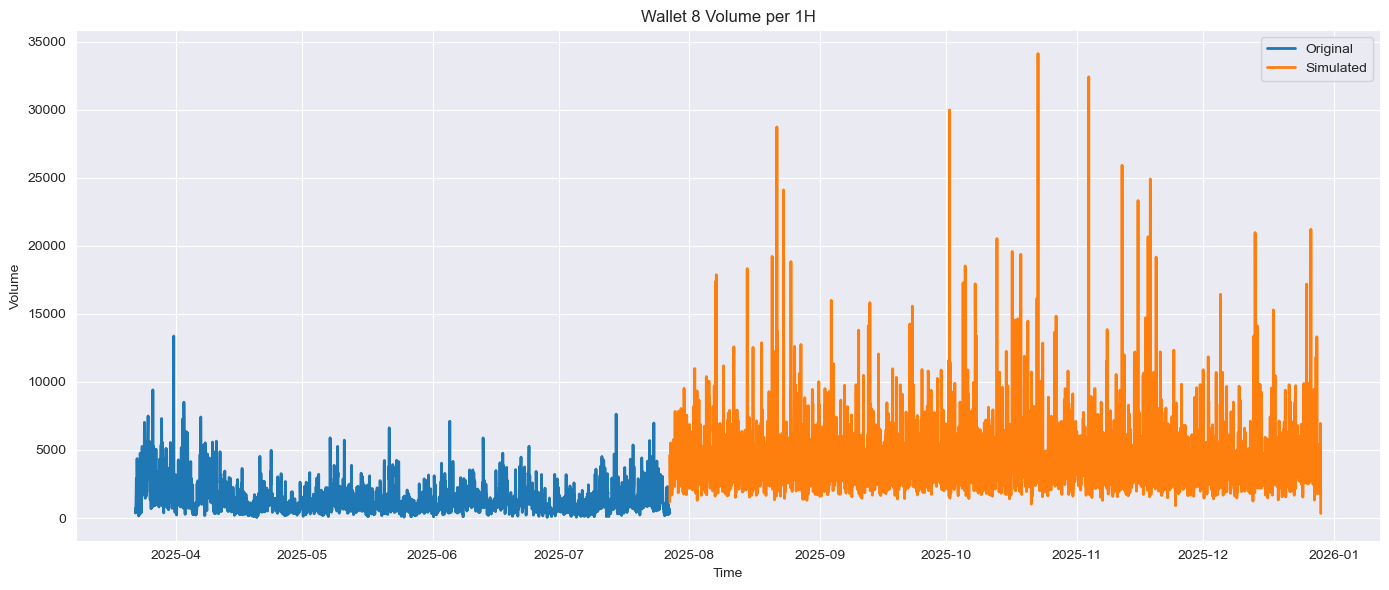

In [15]:
compare_wallet_volume(df_all_matched, df_simulated, wallet_id=8)

In [16]:
time_diff_s = 10 * 60 # 1 minute difference
price_diff_pct = 0.01
size_diff_pct = 0.01

In [19]:
from src.simple_wash_detector_utils import detect_wash_trades_local

print(f"number\t - volume share\t - count share")
sim_time_detected = detect_wash_trades_local(df_simulated, time_diff_s, price_diff_pct, size_diff_pct, randomization=None, is_final_filtration=True)

sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / (df_simulated["size"].sum() * 2)
sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / df_simulated["size"].shape[0]
print(f"{sim_time_detected_share_volume:.{5}f}\t\t - {sim_time_detected_share_count:.{5}f}")

number	 - volume share	 - count share


/home/asevlad/program_files/github_asevlad/Hyperliquid_Wash_Trading_detection/src/simple_wash_detector_utils.py:368: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ], axis=1).rename(columns={0:"count", "open_size":"wash_count"}).fillna(0)


0.00000		 - 0.00000


## Naive Bot Wash

In [186]:
def inject_wash_trades(df,
                        n_wash_wallets=5,
                        volume_pct=0.05,
                        count_pct=0.05,
                        wash_delay_seconds=10,
                        seed=None):
    """
    Inject naive wash-trading patterns:
    A wash-wallet buys from a random wallet, then 10 seconds later sells to another random wallet.

    df : original dataframe with columns [buyer, seller, time, price, size]
    n_wash_wallets : number of wallets controlled by wash bot
    volume_pct : percentage of total volume that should be synthetic wash trades
    count_pct  : percentage of total trade count that should be synthetic wash trades
    wash_delay_seconds : delay between buy and sell legs

    Returns:
        df_new with additional:
            'is_wash' == 1 for injected wash trades
    """

    if seed is not None:
        np.random.seed(seed)

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time")

    # ----------------------------------------------------------------------
    # Determine totals from real data
    # ----------------------------------------------------------------------
    total_vol = df["size"].sum()
    total_count = df.shape[0]

    target_wash_count  = int(total_count * count_pct)

    # Each wash cycle = buy leg + sell leg = 2 trades
    n_cycles = max(1, target_wash_count // 2)

    # Choose wash-trading wallets (these perform the buy+sell)
    unique_wallets = pd.unique(df["buyer"].tolist() + df["seller"].tolist())
    wash_wallets = np.random.choice(unique_wallets, size=n_wash_wallets, replace=False)
    print(wash_wallets)

    # Other wallets (to buy from / sell to)
    other_wallets = [w for w in unique_wallets if w not in wash_wallets]
    if len(other_wallets) == 0:
        raise ValueError("Not enough wallets to construct buy-from/sell-to structure.")

    # ----------------------------------------------------------------------
    # Sampling sizes for synthetic wash trades
    # ----------------------------------------------------------------------
    sizes = df["size"].values
    price_series = df.sort_values("time")["price"].values

    mean_size, std_size = np.sum(sizes) * volume_pct / n_cycles, np.std(sizes)
    if std_size <= 0:
        std_size = mean_size * 0.3

    # Start timestamps from end of dataset
    current_time = df["time"].min() + datetime.timedelta(days=np.random.uniform((df["time"].max() - df["time"].min()).days / 2))

    synthetic_records = []

    # ----------------------------------------------------------------------
    # Generate wash-trading cycles
    # ----------------------------------------------------------------------
    for _ in tqdm(range(n_cycles), desc="Injecting wash trades"):
        # Pick which wash-wallet executes this cycle
        ww = int(np.random.choice(wash_wallets))

        # Pick random external seller & buyer
        seller_ext = int(np.random.choice(other_wallets))
        buyer_ext  = int(np.random.choice(other_wallets))

        # Ensure they’re different from the wash wallet
        while seller_ext == ww:
            seller_ext = int(np.random.choice(other_wallets))
        while buyer_ext == ww:
            buyer_ext = int(np.random.choice(other_wallets))

        # Sample trade size
        size = max(1e-8, np.random.normal(mean_size, std_size))

        # Pick price around last known price
        last_price = price_series[-1]
        price = last_price * np.exp(np.random.normal(0, 0.002))

        # BUY leg
        t_buy = current_time + pd.Timedelta(seconds=np.random.randint(1, 60))

        synthetic_records.append({
            "buyer": ww,
            "seller": seller_ext,
            "time": t_buy,
            "price": price,
            "size": size,
            "wash": "Naive"
        })

        # SELL leg 10 seconds later
        t_sell = t_buy + pd.Timedelta(seconds=wash_delay_seconds)

        synthetic_records.append({
            "buyer": buyer_ext,
            "seller": ww,
            "time": t_sell,
            "price": price,
            "size": size,
            "wash": "Naive"
        })

        # Move internal time pointer forward
        current_time = t_sell

    # ----------------------------------------------------------------------
    # Merge and sort
    # ----------------------------------------------------------------------
    df_new = pd.concat([df, pd.DataFrame(synthetic_records)], ignore_index=True)
    df_new = df_new.sort_values("time").reset_index(drop=True)

    return df_new

In [187]:
df_simulated_wash = inject_wash_trades(
    df_simulated,
    n_wash_wallets=5,
    volume_pct=0.1,
    count_pct=0.05,
    wash_delay_seconds=10
)

[181385 110264  37821  41481  35562]


Injecting wash trades:   0%|          | 0/27500 [00:00<?, ?it/s]

### No filtration

In [195]:
from src.simple_wash_detector_utils import detect_wash_trades_local

print(f"number\t - volume share\t - count share")
sim_time_detected = detect_wash_trades_local(df_simulated_wash, time_diff_s, price_diff_pct, size_diff_pct,
                                             randomization=None,
                                             bin_freq = "1ns",
                                             round_mode = "ceil",
                                             is_final_filtration=False
                                             )

sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / df_simulated_wash["size"].sum() / 2
sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / df_simulated_wash.shape[0]
print(f"{sim_time_detected_share_volume:.{5}f}\t\t - {sim_time_detected_share_count:.{5}f}")

number	 - volume share	 - count share
0.08815		 - 0.02459


In [196]:
import warnings
warnings.filterwarnings("ignore")

In [197]:
df_matrix_prediction = df_detected_to_labeled(df_simulated_wash, sim_time_detected)
analyze_labels(df_matrix_prediction)

=== Confusion Matrix ===
TP (correct wash detected):      56776
FP (false wash alarms):          0
FN (missed wash trades):         36
TN (correct non-wash):           1098188

=== Metrics ===
Accuracy:       1.0000
Precision:      1.0000
Recall:         0.9994
F1 Score:       0.9997

=== Error Rates ===
False Positive Rate:  0.0000
False Negative Rate:  0.0006

=== Classification Report ===
              precision    recall  f1-score   support

     No Wash       1.00      1.00      1.00   1098188
        Wash       1.00      1.00      1.00     56812

    accuracy                           1.00   1155000
   macro avg       1.00      1.00      1.00   1155000
weighted avg       1.00      1.00      1.00   1155000



### With filtration

In [198]:
from src.simple_wash_detector_utils import detect_wash_trades_local

print(f"number\t - volume share\t - count share")
sim_time_detected = detect_wash_trades_local(df_simulated_wash, time_diff_s, price_diff_pct, size_diff_pct,
                                             randomization=None,
                                             bin_freq = "1ns",
                                             round_mode = "ceil",
                                             is_final_filtration=True
                                             )

sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / df_simulated_wash["size"].sum() / 2
sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / df_simulated_wash.shape[0]
print(f"{sim_time_detected_share_volume:.{5}f}\t\t - {sim_time_detected_share_count:.{5}f}")

number	 - volume share	 - count share
0.08782		 - 0.02380


In [199]:
df_matrix_prediction = df_detected_to_labeled(df_simulated_wash, sim_time_detected)
analyze_labels(df_matrix_prediction)

=== Confusion Matrix ===
TP (correct wash detected):      54964
FP (false wash alarms):          0
FN (missed wash trades):         36
TN (correct non-wash):           1100000

=== Metrics ===
Accuracy:       1.0000
Precision:      1.0000
Recall:         0.9993
F1 Score:       0.9997

=== Error Rates ===
False Positive Rate:  0.0000
False Negative Rate:  0.0007

=== Classification Report ===
              precision    recall  f1-score   support

     No Wash       1.00      1.00      1.00   1100000
        Wash       1.00      1.00      1.00     55000

    accuracy                           1.00   1155000
   macro avg       1.00      1.00      1.00   1155000
weighted avg       1.00      1.00      1.00   1155000



# Cycle Wash bot

In [200]:
def inject_distributed_partner_bot(df,
                                   n_wash_wallets=6,
                                   volume_pct=0.05,
                                   count_pct=0.05,
                                   cycle_length=3,
                                   wash_gap_seconds=5,
                                   seed=None):
    """
    Inject distributed partner wash trading:
    Wallets trade in a directed cycle:
        w0 -> w1
        w1 -> w2
        ...
        w(k-1) -> w0

    Parameters
    ----------
    df : pd.DataFrame
        Must contain buyer, seller, time, size, price.
    n_wash_wallets : int
        Total wallets controlled by wash trader. Must be >= cycle_length.
    volume_pct : float
        Target wash trading volume / total original volume.
    count_pct : float
        Target wash trading count / total original count.
    cycle_length : int
        Size of each cycle group (3–6 recommended).
    wash_gap_seconds : int
        Averaged time between leg trades inside the cycle.
    seed : int or None

    Returns
    -------
    df_new : DataFrame
        With injected wash trades and column is_wash = {0,1}.
    """

    if seed is not None:
        np.random.seed(seed)

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time")

    # ------------------------------------------------------------------
    # Determine totals
    # ------------------------------------------------------------------
    total_vol = df["size"].sum()
    total_count = df.shape[0]

    target_wash_vol = total_vol * volume_pct
    target_wash_count = int(total_count * count_pct)

    # Each cycle produces "cycle_length" trades
    max_cycles = max(1, target_wash_count // cycle_length)

    # Pick wash wallets
    all_wallets = pd.unique(df["buyer"].tolist() + df["seller"].tolist())
    if n_wash_wallets > len(all_wallets):
        raise ValueError("Not enough wallets in dataset to pick wash wallets.")

    wash_wallets = np.random.choice(all_wallets, size=n_wash_wallets, replace=False)

    # Validate cycle length
    if cycle_length > len(wash_wallets):
        raise ValueError("cycle_length cannot exceed n_wash_wallets")

    # Pick a cycle (ordered)
    cycle_wallets = list(np.random.choice(wash_wallets, size=cycle_length, replace=False))
    print(cycle_wallets)

    # ------------------------------------------------------------------
    # Sampling distributions
    # ------------------------------------------------------------------
    mean_size = df["size"].mean()
    std_size = df["size"].std()
    if not np.isfinite(std_size) or std_size <= 0:
        std_size = mean_size * 0.3

    last_price = df.sort_values("time")["price"].iloc[-1]

    current_time = df["time"].min() + datetime.timedelta(days=np.random.uniform((df["time"].max() - df["time"].min()).days / 2))

    synthetic = []
    cum_volume = 0.0

    # ------------------------------------------------------------------
    # Generate wash cycles
    # ------------------------------------------------------------------
    for _ in tqdm(range(max_cycles), desc="Injecting distributed cycles"):
        # Trade through the cycle:
        # (w0 -> w1), (w1 -> w2), ..., (w(k-1) -> w0)

        for i in range(cycle_length):
            seller = int(cycle_wallets[i])
            buyer = int(cycle_wallets[(i + 1) % cycle_length])

            # Sample trade size
            size = max(0.1, np.random.normal(mean_size, std_size))

            # Update cumulative volume
            cum_volume += size
            if cum_volume >= target_wash_vol:
                break

            # Sample price around last price
            price = last_price * np.exp(np.random.normal(0, 0.002))

            # Time increment
            dt = np.random.randint(1, wash_gap_seconds)
            current_time = current_time + pd.Timedelta(seconds=dt)

            synthetic.append({
                "buyer": buyer,
                "seller": seller,
                "time": current_time,
                "price": price,
                "size": size,
                "wash": "Cycle"
            })

        if cum_volume >= target_wash_vol:
            break

    # ------------------------------------------------------------------
    # Merge and return
    # ------------------------------------------------------------------
    df_new = pd.concat([df, pd.DataFrame(synthetic)], ignore_index=True)
    df_new = df_new.sort_values("time").reset_index(drop=True)

    return df_new


In [201]:
df_with_cycle_wash = inject_distributed_partner_bot(
    df_simulated,
    n_wash_wallets=10,      # choose 10 wallets to form wash networks
    volume_pct=0.03,        # 10% artificial volume
    count_pct=0.01,         # 5% of trades
    cycle_length=5,         # 4-wallet loop (A→B→C→D→E→A)
    wash_gap_seconds=8
)

df_with_cycle_wash = inject_distributed_partner_bot(
    df_with_cycle_wash,
    n_wash_wallets=10,      # choose 10 wallets to form wash networks
    volume_pct=0.03,        # 10% artificial volume
    count_pct=0.01,         # 5% of trades
    cycle_length=4,         # 4-wallet loop (A→B→C→D→A)
    wash_gap_seconds=8
)

df_with_cycle_wash = inject_distributed_partner_bot(
    df_with_cycle_wash,
    n_wash_wallets=10,      # choose 10 wallets to form wash networks
    volume_pct=0.03,        # 10% artificial volume
    count_pct=0.01,         # 5% of trades
    cycle_length=3,         # 4-wallet loop (A→B→C→A)
    wash_gap_seconds=8
)

df_with_cycle_wash = inject_distributed_partner_bot(
    df_with_cycle_wash,
    n_wash_wallets=10,      # choose 10 wallets to form wash networks
    volume_pct=0.03,        # 10% artificial volume
    count_pct=0.01,         # 5% of trades
    cycle_length=2,         # 4-wallet loop (A→B→A)
    wash_gap_seconds=5
)

[np.int64(228983), np.int64(16314), np.int64(92527), np.int64(175869), np.int64(172446)]


Injecting distributed cycles:   0%|          | 0/2200 [00:00<?, ?it/s]

[np.int64(169295), np.int64(62610), np.int64(96898), np.int64(36866)]


Injecting distributed cycles:   0%|          | 0/2777 [00:00<?, ?it/s]

[np.int64(133431), np.int64(213669), np.int64(43594)]


Injecting distributed cycles:   0%|          | 0/3740 [00:00<?, ?it/s]

[np.int64(116749), np.int64(23559)]


Injecting distributed cycles:   0%|          | 0/5666 [00:00<?, ?it/s]

### No filtration

In [202]:
print(f"volume share\t - count share")
df_with_cycle_wash["time"] = df_with_cycle_wash["time"].astype("datetime64[ms]")
sim_time_detected = detect_wash_trades_local(df_with_cycle_wash, time_diff_s, price_diff_pct, size_diff_pct,
                                             randomization=None,
                                             bin_freq = "1ns",
                                             round_mode = "ceil",
                                             is_final_filtration=False
                                             )

sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / (df_simulated["size"].sum() * 2)
sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / df_simulated.shape[0]
print(f"{sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

volume share	 - count share
0.001		 - 0.009


In [203]:
df_matrix_prediction = df_detected_to_labeled(df_with_cycle_wash, sim_time_detected)
analyze_labels(df_matrix_prediction)

=== Confusion Matrix ===
TP (correct wash detected):      14638
FP (false wash alarms):          0
FN (missed wash trades):         31834
TN (correct non-wash):           1098188

=== Metrics ===
Accuracy:       0.9722
Precision:      1.0000
Recall:         0.3150
F1 Score:       0.4791

=== Error Rates ===
False Positive Rate:  0.0000
False Negative Rate:  0.6850

=== Classification Report ===
              precision    recall  f1-score   support

     No Wash       0.97      1.00      0.99   1098188
        Wash       1.00      0.31      0.48     46472

    accuracy                           0.97   1144660
   macro avg       0.99      0.66      0.73   1144660
weighted avg       0.97      0.97      0.97   1144660



### With filtration

In [204]:
print(f"volume share\t - count share")
df_with_cycle_wash["time"] = df_with_cycle_wash["time"].astype("datetime64[ms]")
sim_time_detected = detect_wash_trades_local(df_with_cycle_wash, time_diff_s, price_diff_pct, size_diff_pct,
                                             randomization=None,
                                             bin_freq = "1ns",
                                             round_mode = "ceil",
                                             is_final_filtration=True
                                             )

sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / (df_simulated["size"].sum() * 2)
sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / df_simulated.shape[0]
print(f"{sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

volume share	 - count share
0.001		 - 0.009


In [205]:
df_matrix_prediction = df_detected_to_labeled(df_with_cycle_wash, sim_time_detected)
analyze_labels(df_matrix_prediction)

=== Confusion Matrix ===
TP (correct wash detected):      12826
FP (false wash alarms):          0
FN (missed wash trades):         31834
TN (correct non-wash):           1100000

=== Metrics ===
Accuracy:       0.9722
Precision:      1.0000
Recall:         0.2872
F1 Score:       0.4462

=== Error Rates ===
False Positive Rate:  0.0000
False Negative Rate:  0.7128

=== Classification Report ===
              precision    recall  f1-score   support

     No Wash       0.97      1.00      0.99   1100000
        Wash       1.00      0.29      0.45     44660

    accuracy                           0.97   1144660
   macro avg       0.99      0.64      0.72   1144660
weighted avg       0.97      0.97      0.96   1144660

